<a href="https://colab.research.google.com/github/IkireziI/TechSupport-Chatbot/blob/main/TechSupport_Chatbot_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TECH SUPPORT CHATBOT

# DEFINITION



The Tech Support Chatbot is an Artificial Intelligence program designed to automatically answer common technical support questions

# HOW IT WORKS

**Base Model**: It starts with a powerful pre-trained language model called T5-small. This model already has a vast understanding of language.
**Fine-tuning (Learning)**: We then "fine-tuned" this T5-small model by showing it a special dataset of user questions about tech support issues and corresponding correct tech support answers. This process teaches the model to specialize in tech support language and troubleshooting.
**Inference (Responding)**: When you type a question into the chatbot, it processes your question using what it learned during fine-tuning and generates the most relevant tech support response it can.
**Gradio Interface**: The Gradio interface is simply the web-based "chat window" that makes it easy for you to type questions and see the chatbot's answers in real-time.



# Install necessary libraries

In [1]:
!pip install transformers
!pip install scikit-learn
!pip install pandas
!pip install matplotlib seaborn
!pip install pyarrow
!pip install -q transformers datasets pandas scikit-learn matplotlib evaluate accelerate torch sentencepiece gradio
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24

# Core Imports

In [3]:
# Core Imports for the entire notebook
import torch
import tensorflow as tf
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
from datasets import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import evaluate
import gradio as gr


print("--- Installing/Upgrading essential libraries for PyTorch ---")


--- Installing/Upgrading essential libraries for PyTorch ---


In [4]:

# Define global constants and load tokenizer/model_name early
model_name = "t5-small"
MAX_TOKEN_LENGTH = 64
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("--- STEP 1 COMPLETE ---")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

--- STEP 1 COMPLETE ---


#  Data Loading and Preprocessing

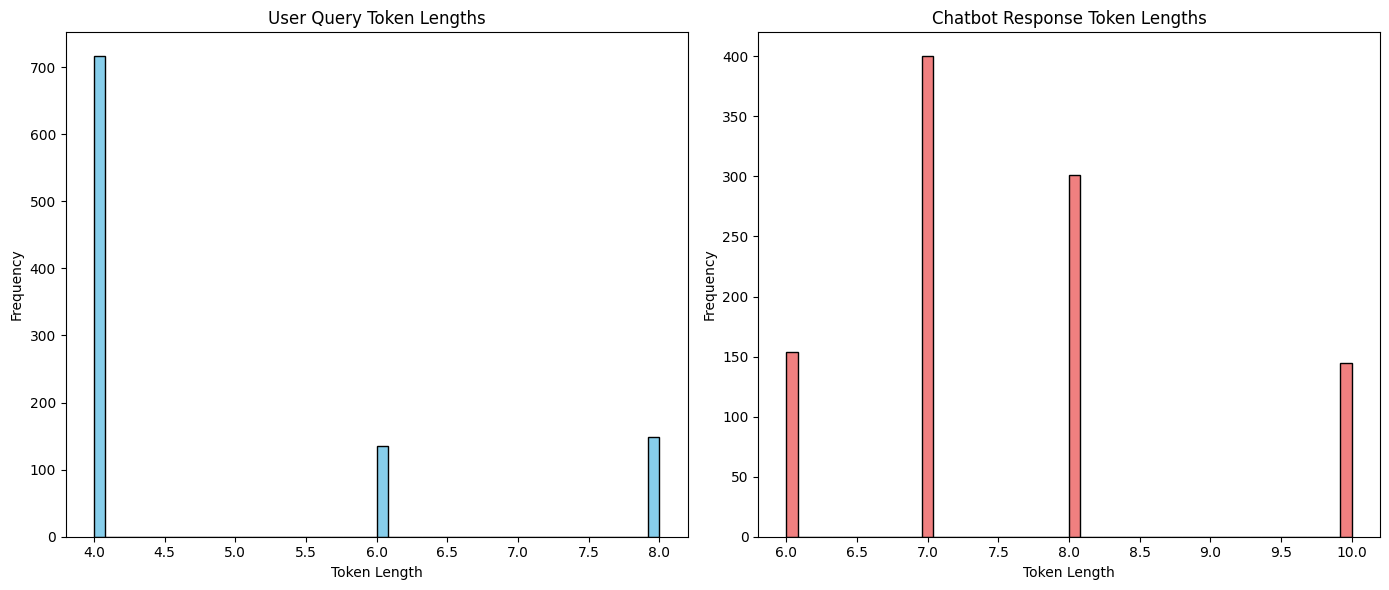

Data loaded and preprocessed.


In [5]:
#  Data Loading and Preprocessing

# Imports for Data Handling
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset


df = pd.read_csv('/content/tech_support_dataset.csv')

# Subset for faster training
df = df.head(1000)

# Rename columns
df.rename(columns={'Customer_Issue': 'user_query', 'Tech_Response': 'chatbot_response'}, inplace=True)
df.drop(columns=['Issue_Category', 'Resolution_Time', 'Issue_Status', 'Conversation_ID'], errors='ignore', inplace=True)
df.fillna('', inplace=True) # Handle missing values

# Token length visualization
def get_token_lengths(texts, tokenizer):
    return [len(tokenizer.encode(text)) for text in texts]

user_query_lengths = get_token_lengths(df['user_query'], tokenizer)
chatbot_response_lengths = get_token_lengths(df['chatbot_response'], tokenizer)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(user_query_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('User Query Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(chatbot_response_lengths, bins=50, color='lightcoral', edgecolor='black')
plt.title('Chatbot Response Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Data loaded and preprocessed.")

#  Data Tokenization and Dataset Creation

In [6]:
#  Data Tokenization and Dataset Creation

# Imports for Tokenization and Dataset
from datasets import Dataset
from transformers import AutoTokenizer
import torch

def tokenize_function_for_training(examples):
    inputs = [f"question: {q}" for q in examples["user_query"]]
    # Return PyTorch tensors ('pt')
    model_inputs = tokenizer(inputs, max_length=MAX_TOKEN_LENGTH, truncation=True, padding="max_length", return_tensors="pt")
    with tokenizer.as_target_tokenizer():
        # Return PyTorch tensors ('pt') for labels too
        labels = tokenizer(examples["chatbot_response"], max_length=MAX_TOKEN_LENGTH, truncation=True, padding="max_length", return_tensors="pt")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

hf_dataset = Dataset.from_pandas(df)
tokenized_hf_dataset = hf_dataset.map(tokenize_function_for_training, batched=True, remove_columns=hf_dataset.column_names)

train_test_split_dataset = tokenized_hf_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split_dataset['train']
val_dataset = train_test_split_dataset['test']

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print("Data tokenized for PyTorch.")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Training dataset size: 800
Validation dataset size: 200
Data tokenized for PyTorch.


# Model Loading

In [13]:
# Model Loading and Metrics Definition

# Imports for Model and Metrics
from transformers import AutoModelForSeq2SeqLM
import evaluate
import numpy as np
import torch

# Load PyTorch T5 model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
print(f"Model '{model_name}' loaded for fine-tuning with PyTorch.")

# Load evaluation metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    # Unpack predictions and labels correctly from the EvalPrediction object
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids


    # If 'predictions' is a tuple (e.g., (logits, hidden_states)), take the first element.
    # This handles cases where the model's output is not just logits.
    if isinstance(predictions, tuple):
        predictions = predictions[0]


    # Ensure predictions and labels are NumPy arrays
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()


    if predictions.ndim == 3: # Format: (batch_size, sequence_length, vocab_size)
        predictions = np.argmax(predictions, axis=-1)


    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_labels_for_metrics = [[label] for label in decoded_labels]

    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels_for_metrics)
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels_for_metrics, use_stemmer=True)

    return {"bleu": bleu_result["bleu"], "rougeL_f1": rouge_result["rougeLsum"]}

print("Evaluation metrics (BLEU, ROUGE) loaded and compute_metrics defined.")

Model 't5-small' loaded for fine-tuning with PyTorch.
Evaluation metrics (BLEU, ROUGE) loaded and compute_metrics defined.


# Training Arguments and Trainer Setup

In [14]:
#  Training Arguments and Trainer Setup

# Imports for Trainer
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq

# Define training arguments (mostly same, but for PyTorch backend)
training_args = TrainingArguments(
    output_dir="./results_pt",
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir="./logs_pt",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    gradient_accumulation_steps=4
)

# Data collator for PyTorch
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt") # Return PyTorch tensors

# Initialize the PyTorch Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("PyTorch Trainer initialized with arguments.")

PyTorch Trainer initialized with arguments.


/tmp/ipython-input-14-2583782638.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer( # Now using the standard Trainer


# Model Training

In [15]:
#  Model Training Execution

print("\nStarting PyTorch model fine-tuning...")
trainer.train()
print("\nPyTorch model fine-tuning complete!")


Starting PyTorch model fine-tuning...


Epoch,Training Loss,Validation Loss,Bleu,Rougel F1
1,0.488600,0.359176,0.361521,0.513045
2,0.134400,0.074306,0.785131,0.826768
3,0.079300,0.048515,0.789206,0.829667
4,0.059500,0.039356,0.789206,0.830762
5,0.051800,0.035391,0.789206,0.830762
6,0.047800,0.034115,0.789206,0.830762
7,0.047100,0.033326,0.789206,0.830762
8,0.045500,0.032902,0.789206,0.829667
9,0.045900,0.032660,0.789206,0.829667
10,0.045100,0.032651,0.789206,0.829667


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



PyTorch model fine-tuning complete!


# Training Evaluation and Plotting


--- Evaluating PyTorch Model Performance ---


Evaluation Results: {'eval_loss': 0.032650578767061234, 'eval_bleu': 0.7892063397863606, 'eval_rougeL_f1': 0.8296666666666674, 'eval_runtime': 110.2887, 'eval_samples_per_second': 1.813, 'eval_steps_per_second': 0.907, 'epoch': 10.0}


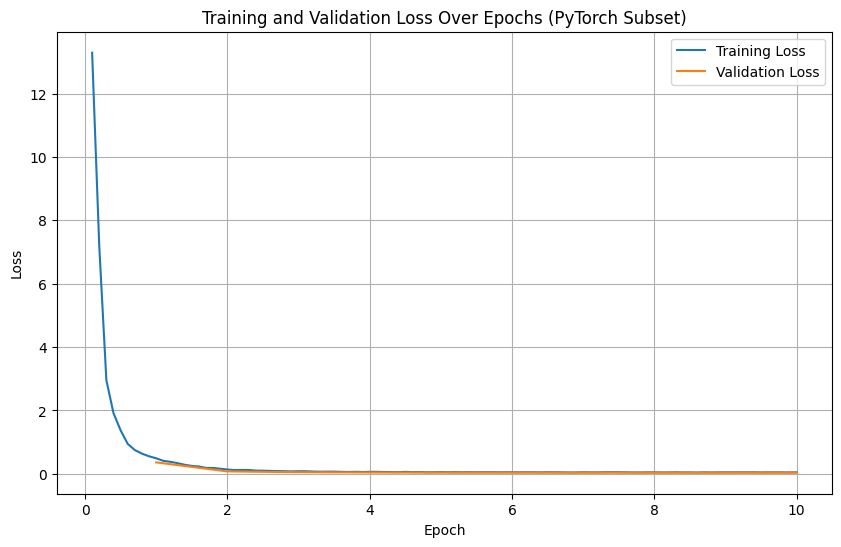

Training and Validation Loss Plot generated.


In [16]:
#  Post-Training Evaluation and Plotting

import matplotlib.pyplot as plt # Import again if not globally available after restart

print("\n--- Evaluating PyTorch Model Performance ---")
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

training_history = trainer.state.log_history

train_losses = []
eval_losses = []
epochs = []
epochs_eval = []

for log in training_history:
    if 'loss' in log and 'epoch' in log:
        train_losses.append(log['loss'])
        epochs.append(log['epoch'])
    if 'eval_loss' in log and 'epoch' in log:
        eval_losses.append(log['eval_loss'])
        epochs_eval.append(log['epoch'])

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs_eval, eval_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs (PyTorch Subset)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("Training and Validation Loss Plot generated.")

#  Save Fine-tuned Model

In [17]:
 #  Save Fine-tuned Model

# Define a path to save your final model
save_path = "./my_finetuned_t5_pt_model"

# Save the model and tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"\nFine-tuned PyTorch model and tokenizer saved to: {save_path}")


Fine-tuned PyTorch model and tokenizer saved to: ./my_finetuned_t5_pt_model


# Pushing Model To Hugging Face Hub

In [20]:
#  PUSHING MODEL TO HUGGING FACE HUB

from huggingface_hub import notebook_login
import os


notebook_login()


hub_model_id = "ikirezii/my-t5-tech-chatbot"

print(f"\nPushing model and tokenizer to Hugging Face Hub: {hub_model_id}...")

# Push tokenizer and model
# These functions require your 'model' and 'tokenizer' variables to be defined,
# which they are after running cells 1-6/8.
tokenizer.push_to_hub(hub_model_id)
model.push_to_hub(hub_model_id)

print("\nModel and tokenizer successfully pushed to Hugging Face Hub!")
print(f"You can view your model here: https://huggingface.co/{hub_model_id}")


Pushing model and tokenizer to Hugging Face Hub: ikirezii/my-t5-tech-chatbot...


Uploading...:   0%|          | 0.00/792k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Uploading...:   0%|          | 0.00/242M [00:00<?, ?B/s]


Model and tokenizer successfully pushed to Hugging Face Hub!
You can view your model here: https://huggingface.co/ikirezii/my-t5-tech-chatbot


# Chatbot Deployment

In [18]:
#  Gradio Chatbot Deployment

import gradio as gr
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

# --- Model Loading for Inference (Choose one option) ---

inference_tokenizer = tokenizer
inference_model = model



def chatbot_inference(user_input):
    input_text = f"question: {user_input}"
    # Tokenize input, return PyTorch tensors
    inputs = inference_tokenizer(
        input_text,
        return_tensors="pt", # Return PyTorch tensors
        max_length=MAX_TOKEN_LENGTH,
        truncation=True,
        padding="max_length"
    )

    # Move input tensors to the same device as the model (e.g., 'cuda' or 'cpu')
    if hasattr(inference_model, 'device'): # Check if model has a device property
        inputs = {k: v.to(inference_model.device) for k, v in inputs.items()}
    elif torch.cuda.is_available(): # Fallback for models without direct device property
        inputs = {k: v.to('cuda') for k, v in inputs.items()}
    else:
        inputs = {k: v.to('cpu') for k, v in inputs.items()}


    # Generate response from the model
    output_sequences = inference_model.generate(
        inputs["input_ids"],
        max_new_tokens=MAX_TOKEN_LENGTH,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    # Decode the generated token IDs back into human-readable text
    generated_response = inference_tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    return generated_response

# Create the Gradio interface
iface = gr.Interface(
    fn=chatbot_inference,
    inputs=gr.Textbox(lines=2, placeholder="Type your tech support query here..."),
    outputs="text",
    title="Tech Support Chatbot (Fine-tuned T5-small - PyTorch)",
    description="Ask the chatbot a tech support question and get a generated response."
)

print("\nLaunching Gradio interface...")
iface.launch(share=True)
print("\nGradio interface launched. Look for the public URL above (usually ends with .gradio.app)")


Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://792c8a9b56151848a1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



Gradio interface launched. Look for the public URL above (usually ends with .gradio.app)
